In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import figure
import statistics
import mysql.connector
import networkx as nx
import numpy as np
import json
import requests
from collections import Counter
import time
import pickle
from functools import reduce
import math
import seaborn as sns

In [12]:
import mysql.connector
import pandas as pd

# Database Connection

In [13]:
# Establish database connection
cnx = mysql.connector.connect(user='david', password='daviddung1993',
                              host='127.0.0.1',
                              database='computervision')
cursor = cnx.cursor()

# Dataset Information

In [14]:
cursor.execute("with temp as (select distinct p.`primary author` as author from Papers p where p.Leaf = False and p.Pub_Year = 2022 and p.`primary author` != 'na')"
               "select t.author, count(p.`primary author`) from temp t left join Papers p on t.author = p.`primary author` and p.Leaf = False and p.Pub_Year < 2022 group by t.author order by count(*) desc")
t = cursor.fetchall()
authors_total = list(filter(lambda x: x[1]>1, t))
val_authors_total = [author[0] for author in authors_total]
in_params = ','.join(['%s'] * len(val_authors_total))
cursor.execute("create temporary table val as (select distinct p.PaperID from Papers p where p.Leaf = False and p.Pub_Year = 2022 and p.`primary author` in (%s))" % in_params, val_authors_total)
cursor.execute("select * from val")
test_papers_total_set = len(cursor.fetchall())
cursor.execute("create temporary table total_set_references as (select distinct b.ReferenceID as PaperID from Papers p, referencedBy b where p.`primary author` in (%s) and b.ReferencedByID = p.PaperID)" % in_params, val_authors_total)
cursor.execute("select * from total_set_references")
total_references = len(cursor.fetchall())

In [15]:
cursor.execute("create temporary table aff_info as (select p.PaperID, count(affiliatedTo)/count(p2.`primary author`) as info from Papers p join referencedBy b on p.PaperID = b.ReferencedByID join Papers p2 on b.ReferenceID = p2.PaperID left join affiliatedTo a on p2.`primary author` = a.AuthorID group by p.PaperID)")
cursor.execute("create temporary table aff_info2 as (select p.PaperID, count(affiliatedTo)/count(p2.`primary author`) as info from Papers p join referencedBy b on p.PaperID = b.ReferencedByID join Papers p2 on b.ReferenceID = p2.PaperID left join affiliatedTo a on p2.`primary author` = a.AuthorID group by p.PaperID)")

In [16]:
cursor.execute("with temp as (select distinct p.`primary author` as author from Papers p, aff_info a where p.Leaf = False and p.Pub_Year = 2022 and p.PaperID = a.PaperID and a.info >= 0.9 and p.`primary author` in (select AuthorID          from affiliatedTo))"
               "select t.author, count(p.`primary author`) from temp t, Papers p, aff_info2 a where t.author = p.`primary author` and p.Leaf = False and p.Pub_Year < 2022 and p.ReferenceCount >= 5 and p.PaperID = a.PaperID and a.info >= 0.9 group by t.author")
#len(cursor.fetchall())

In [17]:
#cursor.execute("with temp as (select distinct p.`primary author` as author from Papers p, aff_info a where p.Leaf = False and p.Pub_Year = 2022 and p.PaperID = a.PaperID and a.aff_info >= 0.9)"
#               "select t.author, count(p.`primary author`) from temp t left join Papers p on t.author = p.`primary author` and p.Leaf = False and p.Pub_Year < 2022 and p.ReferenceCount >= 5 group by t.author order by count(*) desc")
t2 = cursor.fetchall()
authors_ieee = list(filter(lambda x: x[1]>1, t2))
val_authors = [author[0] for author in authors_ieee]
in_params = ','.join(['%s'] * len(val_authors))
cursor.execute("create temporary table val2 as (select p.PaperID from Papers p, aff_info a where p.Leaf = False and p.Pub_Year = 2022 and p.`primary author` in (%s) and a.PaperID = p.PaperID and a.info >= 0.9)" % in_params, val_authors)
cursor.execute("select * from val2")
test_papers_ieee = cursor.fetchall()
cursor.execute("select p.PaperID from Papers p, aff_info a where p.Leaf = False and p.Pub_Year < 2022 and p.`primary author` in (%s) and a.PaperID = p.PaperID and a.info >= 0.9" % in_params, val_authors)
train_papers = cursor.fetchall()
cursor.execute("create temporary table ieee_set_references as (select distinct b.ReferenceID as PaperID from Papers p, referencedBy b where p.`primary author` in (%s) and b.ReferencedByID = p.PaperID)" % in_params, val_authors)
cursor.execute("select * from ieee_set_references")
ieee_references = cursor.fetchall()

In [8]:
len(train_papers), test_papers_ieee

(2385, 1006)

In [20]:
print([x[0] for x in test_papers_ieee])

['002a17b6956ead1668bf2aa8241bebb14c5268c0', '004f1d2b1b7d7dcecafdd94daee9c1b0aa3e65cf', '00d124fab3e4895130f3563bb7e03b18b646a682', '00df26281679ea7215e34ef3bee850e1348492b6', '00ea5b0a1622ada0134e5010ff1bad62c70949e2', '01724c36660359545e1368fc80c99f4bde44a190', '01c6d124fc66250da17a9fbf20ce46c2861b9b25', '01ce9e739a5b12f492b40cf56fa01bf80e1e6327', '01d14d1addd0e325e326161286a71cfc9484f3fb', '01dc0d352fa06260ac8d7c36ff9d6adc63db352c', '021c03ae57cb294dde634edfd5c61897805a1b31', '022fba8542d69a7194ae9108980be2ed501f2d66', '026472f9a8342f8de27803726607debe5a02fc0b', '02951aaa09ce01cf25261ca3acf60d39d78a3267', '029951db615675c5a3ea61b6179838fe2928f8ba', '02b05d03edced4e26eafb632482dc53417ebff0b', '02b1356d3782be6cc790fc89b1d644b426cd8493', '02f1243778bced398c4949cf90629742175ad79b', '02f564e025ec5a02d4a58380634bd9718e323fc5', '0307caf20f0ea22d6ae979b65c7ab85f3abf2af1', '0313384ea47cc1b93ed53b652c8786cce4a2ec02', '0337e102bce3bb7d965e66e96a8761381244ebaa', '033a344b2e13b552aec2dc8089d8c0

In [195]:
number_authors_total = len(authors_total)
number_training_papers_total = reduce(lambda acc,b: acc+b[1],authors_total,0)
number_authors_ieee = len(authors_ieee)
number_training_papers_ieee = reduce(lambda acc,b: acc+b[1],authors_ieee,0)
print(f"Total: Number authors: {number_authors_total}, Number training Papers: {number_training_papers_total}, Number of test Papers: {test_papers_total_set}, Total references: {total_references}")
print(f"IEEE: Number authors: {number_authors_ieee}, Number training Papers: {number_training_papers_ieee}, Number of test Papers: {test_papers_ieee}, Total references: {ieee_references}")

Total: Number authors: 2363, Number training Papers: 8022, Number of test Papers: 3207, Total references: 107899
IEEE: Number authors: 785, Number training Papers: 2383, Number of test Papers: 1171, Total references: 46594


In [4]:
cursor.execute("select p.`primary author` as PaperID from Papers p, referencedBy b where p.`primary author` in (%s) and p.Leaf = 'False' and p.Pub_Year < 2022 and b.ReferencedByID = p.PaperID and p.`primary author` not in (select a.AuthorID from affiliatedTo a) group by p.`primary author`" % in_params, val_authors)
cursor.fetchall()

NameError: name 'in_params' is not defined

In [64]:
cursor.execute("select p.`primary author`, count(*) from Papers p, aff_info af where p.Leaf = False and p.Pub_Year < 2022 and p.`primary author` in (select a.AuthorID from affiliatedTo a) and p.`primary author` in (select p.`primary author` from Papers p, aff_info2 a where p.Leaf=False and p.Pub_Year = 2022 and p.PaperID=a.PaperID and a.info >= 0.95 and p.ReferenceCount >= 5) and p.PaperID = af.PaperID and af.info >= 0.8 group by p.`primary author` order by count(*) desc")
a = cursor.fetchall()
test_authors = [x[0] for x in a]

In [12]:
in_params = ','.join(['%s'] * len(test_authors))

In [82]:
cursor.execute("select distinct p.PaperID, a.info from Papers p, aff_info a where p.PaperID=a.PaperID and a.info >= 0 and p.`primary author` in (%s) and p.Pub_Year = 2022" % in_params, val_authors)
test_set = cursor.fetchall()

In [83]:
with open(r'./test_papers.txt', 'w') as fp:
    for item in test_set:
        # write each item on a new line
        fp.write("%s\n" % item[0])
    print('Done')

Done


In [76]:
cnx.close()

In [8]:
pd.DataFrame(test_set)[0]

0       002a17b6956ead1668bf2aa8241bebb14c5268c0
1       004f1d2b1b7d7dcecafdd94daee9c1b0aa3e65cf
2       00d124fab3e4895130f3563bb7e03b18b646a682
3       00df26281679ea7215e34ef3bee850e1348492b6
4       00ea5b0a1622ada0134e5010ff1bad62c70949e2
                          ...                   
1925    ff9e8b4772f1a3ab0c0b8f8b69ed5e9230861ac2
1926    ffa5b3b69de890ddd14e6a7828fa72d911502461
1927    ffcd8a3942462b99859738badd0130fa91d059be
1928    ffe1ca8a25f2061d1a605c94a8bfe716d627f13a
1929    fff60ef90f7ebfcc48999da55866c79b9ee68549
Name: 0, Length: 1930, dtype: object

In [25]:
pd.DataFrame(list(filter(lambda x: x[1]>1, a)))

,0,1
0,3046649,15
1,145245424,14
2,51122311,11
3,3110004,11
4,3458134,11
...,...,...
841,2108847,2
842,2064397298,2
843,2056454633,2
844,2046925281,2


In [12]:
cursor.execute("select * from Papers p, aff_info f where p.PaperID = f.PaperID and p.Leaf = False and p.Pub_Year = 2022 and p.publisher = 'Institute of Electrical and Electronics Engineers (IEEE)' and f.info >= 0.9")
len(cursor.fetchall())

1381

In [12]:
cursor.execute("select Name from Affiliations")
[x[0] for x in cursor.fetchall()][200:300]


['University of Arkansas',
 'Eagle Vision Systems B.V.',
 'Delft University of Technology',
 'Saint Louis University',
 'Université de Montréal',
 'VisiSonics Corp',
 'IFTM University',
 'University of Exeter',
 'Yale University',
 'Laval University',
 'InterDigital',
 'Siemens',
 'Colorado State University',
 'Weta Digital Ltd.',
 'Lawrence Berkeley National Laboratory',
 'São Paulo State University',
 'Université de Sherbrooke',
 'Atomic Energy and Alternative Energies Commission',
 'Harik Shazeer Labs',
 'Salk Institute for Biological Studies',
 'University of Bedfordshire',
 'University of Iowa',
 'University of New Hampshire',
 'NASA',
 'iCAD Inc',
 'Croatian National Bank',
 'Predictive Technologies Corporation',
 'Amrita Vishwa Vidyapeetham',
 'American Cancer Society',
 'Yeshwant Mahavidyalaya Nanded',
 'Mustansiriyah University',
 'bejing insurance research institute',
 'Drexel University',
 'Flare Networks',
 'University of Lisbon',
 'Walailak University',
 'National Institut

# Graph visualization

In [5]:
cursor.execute("select distinct b.ReferenceID, b.ReferencedByID from Papers p, referencedBy b where p.`primary author` in (%s) and b.ReferencedByID = p.PaperID and p.PaperID not in (select p2.PaperID from Papers p2 where p2.Leaf = False and p2.Pub_Year = 2022 and p2.publisher != 'Institute of Electrical and Electronics Engineers (IEEE)')" % in_params, val_authors)
ieee_set_edges = cursor.fetchall()

In [61]:
node_list = list(set([node[1] for node in ieee_set_edges]))
reference_list = list(set([node[0] for node in ieee_set_edges]))

In [142]:
edges_list = list(filter(lambda x: x[0] in node_list,ieee_set_edges))

In [149]:
node_list2 = list(set([node[1] for node in edges_list]))

1536

In [146]:
nx.write_gexf(G, "graph2.gexf")

# Graph properties

In [49]:
G = nx.DiGraph()
G.add_edges_from(ieee_set_edges)

In [77]:
print("Strong Connectivity")
print(f"Number of strongly connected components: {nx.number_strongly_connected_components(G)}")
print("Weak Connectivity")
print(f"Number of weakly connected components: {nx.number_weakly_connected_components(G)}")
weak_components_length = []
weak_components = []
for wc in nx.weakly_connected_components(G):
    weak_components_length.append(len(wc))
    weak_components.append(wc)
print(f"Unique sizes of weak components: {sorted(weak_components_length, reverse=True)}")

Strong Connectivity
Number of strongly connected components: 39952
Weak Connectivity
Number of weakly connected components: 7
Unique sizes of weak components: [39939, 27, 15, 15, 8, 7, 4]


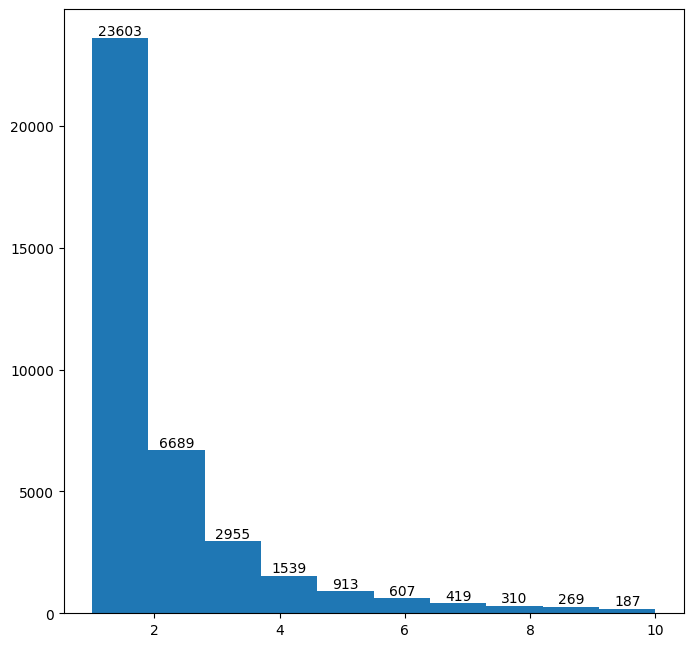

In [79]:
# Create the graph
figure(figsize=(8, 8),dpi=100)
counts, edges, bars = plt.hist([x[1] for x in list(G.out_degree(reference_list))], range=(1,10))
plt.bar_label(bars)
plt.show()

In [95]:
in_params = ','.join(['%s'] * len(node_list))

In [134]:
cursor.execute("select p.PaperID, p.ReferenceCount, p.authorCount from Papers p where p.PaperID in (%s)" % in_params, node_list)
buckets = {}
for i in range(7):
    buckets[i] = list()
for paper_information in cursor.fetchall():
    bucket = math.floor(((paper_information[1] -1) / 10))
    buckets[bucket].append(paper_information[2])
for i in buckets:
    buckets[i] = sum(buckets[i])/len(buckets[i])
indices = []
average_author_count = []
for x in buckets.items():
    indices.append(x[0]*10+5)
    average_author_count.append(x[1])

39.936870642912474
40.0


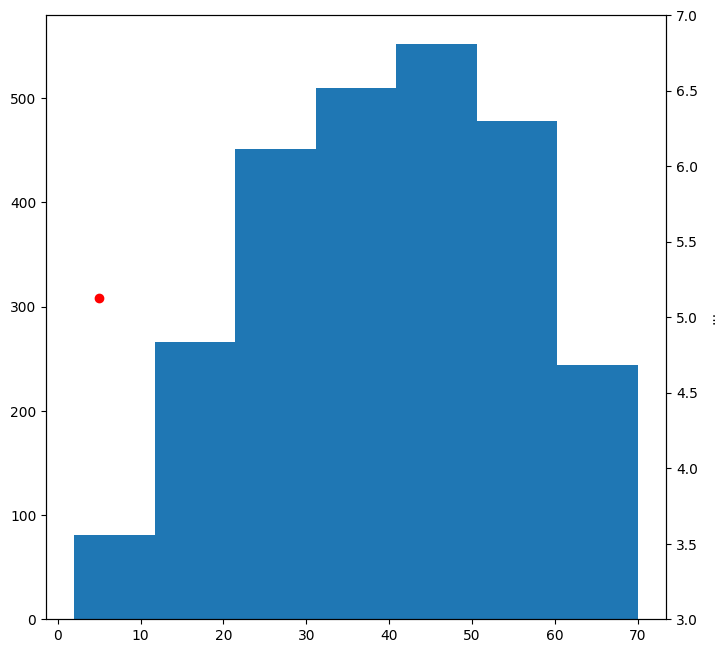

In [136]:
fig = figure(figsize=(8, 8),dpi=100)
axes1 = fig.add_subplot(111)
number_of_outdegrees = [x[1] for x in list(G.in_degree(node_list))]
counts, edges, bars = axes1.hist(number_of_outdegrees, bins=7)
avg_references = sum(number_of_outdegrees)/len(number_of_outdegrees)
median_references = statistics.median(number_of_outdegrees)

# set props for left y-axis here

axes2 = axes1.twinx()   # mirror them
axes2.set_ylabel("...")
axes2.scatter(indices,average_author_count, color="r")
axes2.set_ylim(3,7)
print(avg_references)
print(median_references)
plt.bar_label(bars)
plt.show()

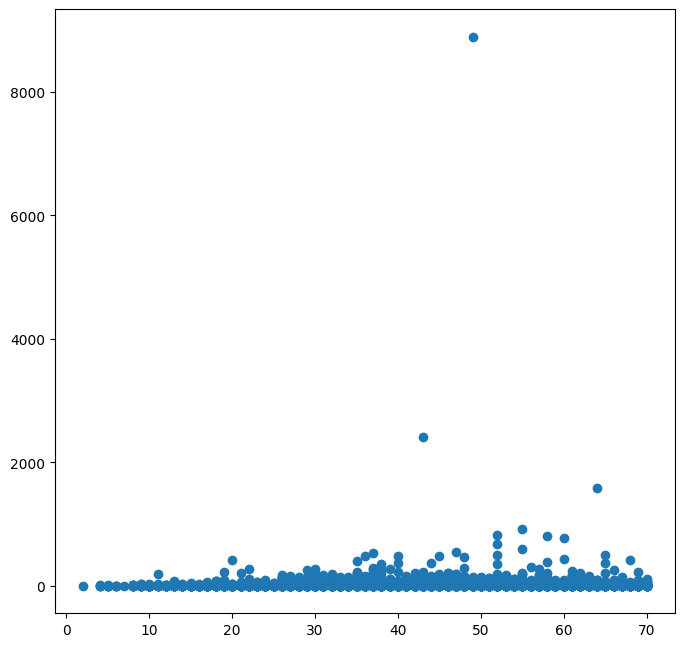

In [147]:
cursor.execute("select p.PaperID, p.ReferenceCount, p.CitationCount from Papers p where p.PaperID in (%s)" % in_params,
               node_list)
influential_references = cursor.fetchall()
figure(figsize=(8, 8),dpi=100)
citation_count = [x[2] for x in influential_references]
references_count = [x[1] for x in influential_references]
plt.scatter(references_count, citation_count)
plt.show()

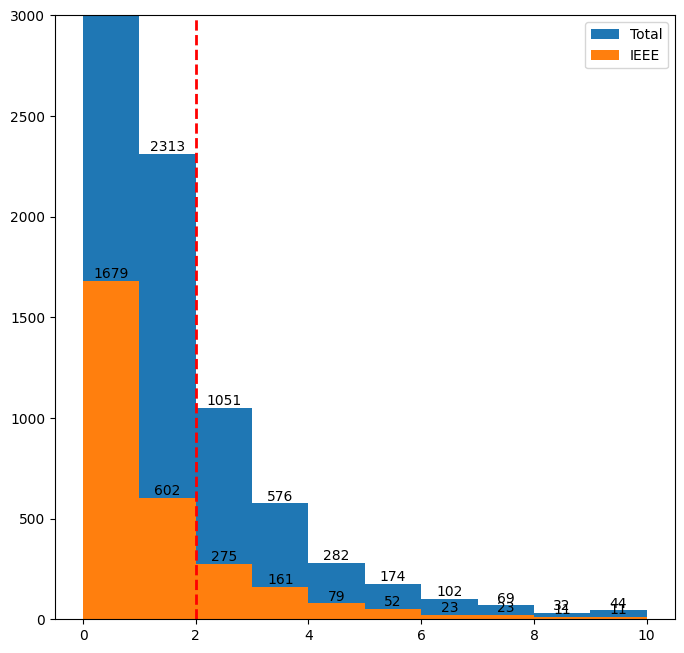

In [105]:
figure(figsize=(8, 8),dpi=100)
counts, edges, bars = plt.hist([x[1] for x in t], range=(0,10), bins=10, label="Total")
counts2, edges2, bars2 = plt.hist([x[1] for x in t2], range=(0,10), bins=10, label="IEEE")
ax = plt.gca()
ax.set_ylim([0, 3000])
plt.axvline(2, color='r', linewidth=2, linestyle="dashed")
plt.legend()
plt.bar_label(bars)
plt.bar_label(bars2)
plt.show()

# Papers Analysis

In [80]:
cursor.execute("select publisher, count(*) from Papers p group by publisher")
sorted(cursor.fetchall(), key=lambda x: x[1], reverse=True)

[('Institute of Electrical and Electronics Engineers (IEEE)', 136503),
 (None, 94157),
 ('Springer Science and Business Media LLC', 59294),
 ('Elsevier BV', 54808),
 ('Association for Computing Machinery (ACM)', 20540),
 ('Wiley', 12912),
 ('MDPI AG', 6939),
 ('Informa UK Limited', 6357),
 ('SPIE-Intl Soc Optical Eng', 6324),
 ('Association for Computational Linguistics (ACL)', 3970),
 ('Association for the Advancement of Artificial Intelligence (AAAI)', 3794),
 ('Optica Publishing Group', 3279),
 ('Oxford University Press (OUP)', 3241),
 ('IOP Publishing', 2975),
 ('SAGE Publications', 2566),
 ('Society for Industrial & Applied Mathematics (SIAM)', 2324),
 ('Ovid Technologies (Wolters Kluwer Health)', 2163),
 ('Public Library of Science (PLoS)', 2094),
 ('Frontiers Media SA', 2024),
 ('Hindawi Limited', 1686),
 ('JSTOR', 1609),
 ('Institution of Engineering and Technology (IET)', 1592),
 ('MIT Press', 1462),
 ('Cambridge University Press (CUP)', 1452),
 ('International Joint Conferenc

In [3]:
cursor.execute("SELECT count(*) FROM Papers p WHERE p.Leaf = TRUE")
total_paper_without_references = cursor.fetchone()[0]
cursor.execute("SELECT count(*) FROM Papers p WHERE p.Leaf = FALSE and p.ReferenceCount is not null")
total_paper_with_references = cursor.fetchone()[0]
cursor.execute("SELECT count(*) FROM Papers p WHERE p.Leaf = FALSE AND p.ReferenceCount > 0")
total_paper_at_least_one = cursor.fetchone()[0]
print(f"Total papers: {total_paper_without_references + total_paper_with_references}")
print(f"Paper references: {total_paper_without_references}")
print(f"Papers: {total_paper_with_references}")
print(f"Papers with at least one reference: {total_paper_at_least_one}")

Total papers: 589389
Paper references: 513792
Papers: 75597
Papers with at least one reference: 75597


In [4]:
cursor.execute("SELECT count(*) FROM Authors a")
total_authors = cursor.fetchone()[0]
cursor.execute("SELECT count(distinct a.AuthorID) from Papers p, Authors a, authoredBy b WHERE p.leaf = False and p.PaperID = b.PaperID and b.AuthoredByID = a.AuthorID")
total_authors_with_references = cursor.fetchone()[0]
print(f"Total authors: {total_authors}")
print(f"Total authors with references: {total_authors_with_references}")
print(f"Avg Authors per paper: {total_authors_with_references/total_paper_with_references}")


Total authors: 733857
Total authors with references: 120508
Avg Authors per paper: 1.5940844213394711


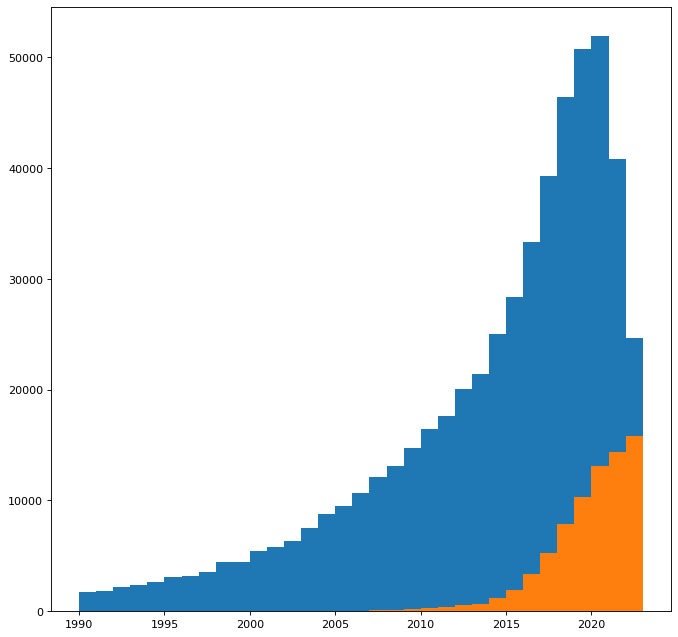

In [6]:
cursor.execute("SELECT p.Pub_Year FROM Papers p")
year_distribution_all = [pub_year[0] for pub_year in cursor.fetchall() if pub_year[0]]
cursor.execute("SELECT p.Pub_Year FROM Papers p WHERE p.Leaf = FALSE")
year_distribution = [pub_year[0] for pub_year in cursor.fetchall() if pub_year[0]]
figure(figsize=(10, 10), dpi=80)
plt.hist(year_distribution_all, bins=33, range=(1990,2023))
plt.hist(year_distribution, bins=33, range=(1990,2023))
plt.show()

In [8]:
cursor.execute("SELECT p.journalName,COUNT(distinct p.PaperID) FROM Papers p group by p.journalName")
journalDistribution = cursor.fetchall()

In [9]:
journalDistribution = sorted(journalDistribution, key=lambda tup: tup[1], reverse=True)
journalDistribution

[('', 33333),
 ('ArXiv', 3828),
 ('IEEE Transactions on Pattern Analysis and Machine Intelligence', 1316),
 ('IEEE Transactions on Image Processing', 1005),
 ('Pattern Recognit.', 920),
 ('International Journal of Computer Vision', 733),
 ('IEEE Trans. Pattern Anal. Mach. Intell.', 525),
 ('Pattern Recognit. Lett.', 507),
 ('IEEE Transactions on Medical Imaging', 487),
 ('Comput. Vis. Image Underst.', 341),
 ('Image Vis. Comput.', 340),
 ('IEEE transactions on image processing : a publication of the IEEE Signal Processing Society',
  330),
 ('2014 IEEE Conference on Computer Vision and Pattern Recognition', 324),
 ('2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR)',
  319),
 ('2013 IEEE Conference on Computer Vision and Pattern Recognition', 306),
 ('2012 IEEE Conference on Computer Vision and Pattern Recognition', 304),
 ('J. Mach. Learn. Res.', 296),
 ('2013 IEEE International Conference on Computer Vision', 286),
 ('IEEE Transactions on Geoscience and Remote Se

# Affiliations

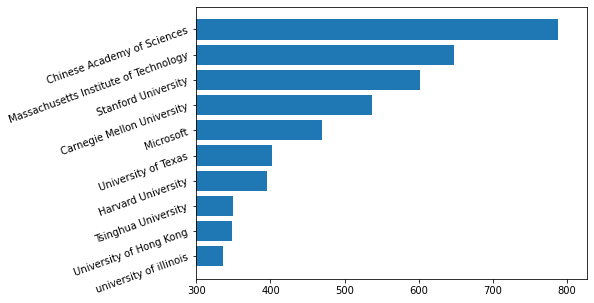

In [4]:
cursor.execute("select Name, count(*) from affiliatedTo a, Affiliations a2 where a.affiliatedTo = a2.AffiliationID group by affiliatedTo, Name order by count(*) DESC")
data = cursor.fetchall()
labels = list(reversed([x[0] for x in data][1:11]))
aff_distribution = list(reversed([x[1] for x in data][1:11]))
y_pos = np.arange(len(aff_distribution))
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_yticks(y_pos, labels=labels)
ax.barh(y_pos, aff_distribution, align='center')
ax.set_xlim(xmin=300)
ax.tick_params(axis='y', labelrotation=20)

1.7390723027872057
1


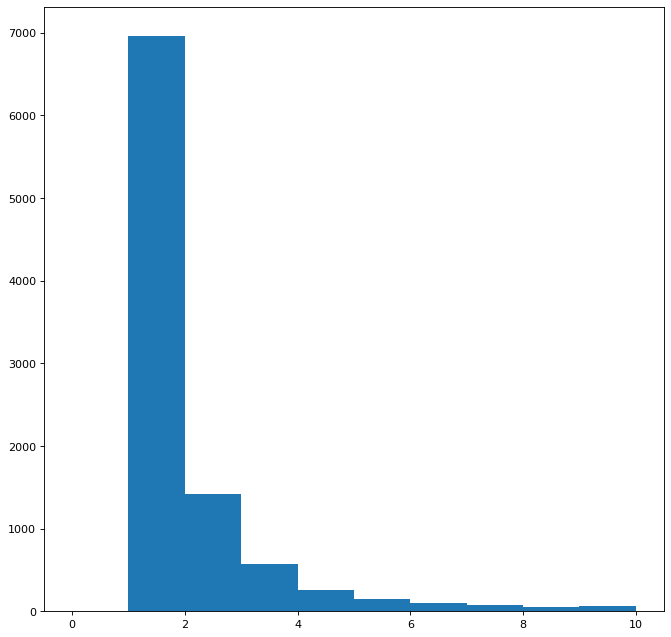

In [6]:
cursor.execute("SELECT count(*) from Papers p, Authors a, authoredBy b WHERE p.leaf = False and p.PaperID = b.PaperID and b.AuthoredByID = a.AuthorID GROUP BY a.AuthorID, a.Name")
author_counts = sorted([author_count[0] for author_count in cursor.fetchall()])
print(statistics.mean(author_counts))
print(statistics.median(author_counts))
figure(figsize=(10, 10),dpi=80)
plt.hist(author_counts, bins=10, range=(0,10))
plt.show()

# Countries

In [7]:
cursor.execute("select Country, count(*) from Affiliations a, affiliatedTo a2 where a.AffiliationID = a2.affiliatedTo group by Country order by count(*) DESC ")
country_distribution = cursor.fetchall()

In [8]:
labels = [country[0] for country in country_distribution]
amounts = [country[1] for country in country_distribution]

In [11]:
final_amount = amounts[:13]
final_amount.append(sum(amounts[13:]))
final_label = labels[:13]
final_label.append("other")

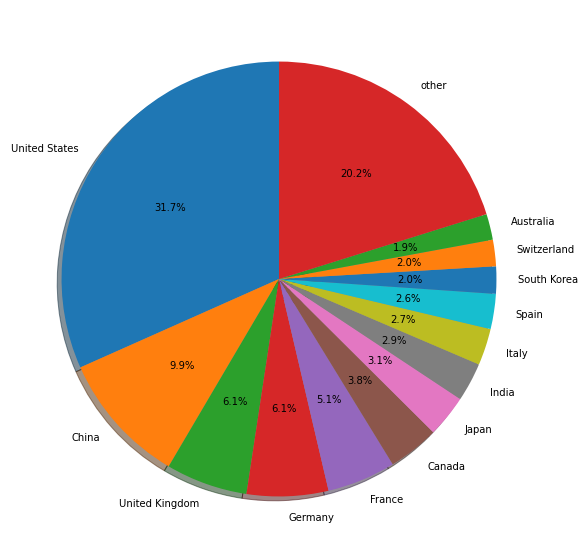

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.pie(final_amount, labels=final_label, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

# Gender

In [11]:
cursor.execute("select Gender, count(*) from Authors a where a.AuthorID in (select p.`primary author` from Papers p where p.Leaf = False and p.Pub_Year < 2022) and (a.Gender = 0 or a.Gender = 1) group by Gender")
gender_distribution = cursor.fetchall()
gender_distribution

[(0, 28367), (1, 7012)]

In [12]:
# Plot distribution of gender references
cursor.execute("select p.gender, avg(p.avg_gender) from (select p.PaperID, a.Gender as gender, avg(a2.Gender) as avg_gender from Papers p, Authors a, referencedBy b, Papers p2, Authors a2 where p.Leaf = False and p.Pub_Year < 2022 and p.`primary author` = a.AuthorID and (a.Gender = 0 or a.Gender = 1) and p.PaperID = b.ReferencedByID and b.ReferenceID = p2.PaperID and p2.`primary author` = a2.AuthorID and (a2.Gender = 0 or a2.Gender = 1) and p.`primary author` != p2.`primary author` group by p.PaperID, a.Gender) p group by p.gender")
cursor.fetchall()

[(0, Decimal('0.15118581')), (1, Decimal('0.16429972'))]

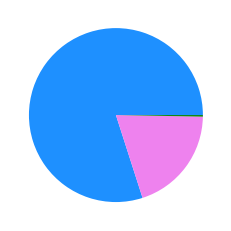

In [7]:
plt.pie([gender_distribution[0][1], gender_distribution[1][1], gender_distribution[2][1]], colors=["dodgerblue","violet","g"])
plt.show()

In [128]:
# Plot distribution of gender references
cursor.execute("select p.PaperID, a.Gender as gender, avg(a2.Gender) as avg_gender from Papers p, Authors a, referencedBy b, Papers p2, Authors a2 where p.Leaf = False and p.Pub_Year = 2022 and p.`primary author` = a.AuthorID and (a.Gender = 0 or a.Gender = 1) and p.PaperID = b.ReferencedByID and b.ReferenceID = p2.PaperID and p2.`primary author` = a2.AuthorID and (a2.Gender = 0 or a2.Gender = 1) and p.ReferenceCount >= 5 group by p.PaperID, a.Gender")
gender_distributions = cursor.fetchall()
male_distribution = []
female_distribution = []
[female_distribution.append(x[2]) if x[1] else male_distribution.append(x[2]) for x in gender_distributions]
print()

In [10]:
print(len(list(filter(lambda x: x >= 0.8, male_distribution))))
print(len(list(filter(lambda x: x >= 0.8, female_distribution))))

1
2


/tmp/ipykernel_238476/3908423441.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(male_distribution, shade=True, label="Male")
/tmp/ipykernel_238476/3908423441.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(female_distribution, shade=True, label="Female")


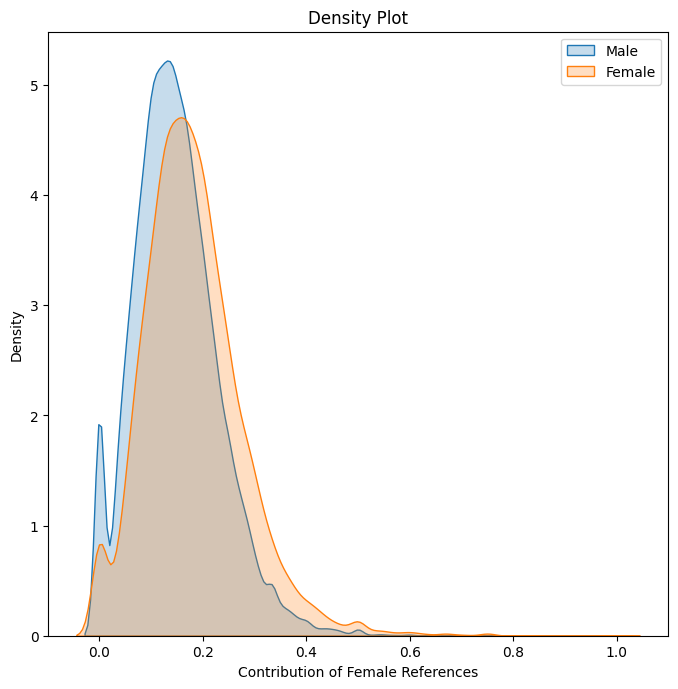

In [11]:
# Create the density plot
figure(figsize=(8, 8),dpi=100)
sns.kdeplot(male_distribution, shade=True, label="Male")
sns.kdeplot(female_distribution, shade=True, label="Female")
# Add labels and title
plt.xlabel('Contribution of Female References')
plt.ylabel('Density')
plt.title('Density Plot')
plt.legend()
# Show the plot
plt.show()

In [120]:
cursor.execute("with temp2 as (with temp as (select p.PaperID, avg(a.Gender)/count(a.Gender) as avg_author_gender from Papers p, authoredBy b, Authors a where p.PaperID = b.PaperID and b.AuthoredByID =       a.AuthorID and (a.Gender = 0 or a.Gender = 1) group by p.PaperID)"
               "select p.PaperID, t.avg_author_gender, avg(a2.Gender) as avg_gender from Papers p, referencedBy b, Papers p2, Authors a2, temp t where p.Leaf = False and p.Pub_Year = 2022 and t.PaperID = p.PaperID and p.PaperID = b.ReferencedByID and b.ReferenceID = p2.PaperID and p2.`primary author` = a2.AuthorID and (a2.Gender = 0 or a2.Gender = 1) and p.ReferenceCount >= 5 group by p.PaperID, t.avg_author_gender)"
               "select t.avg_author_gender, avg(t.avg_gender) from temp2 t group by t.avg_author_gender")
distributions = cursor.fetchall()
male_distribution = [(x[0],x[1]) for x in distributions]

In [ ]:
gender_distributions

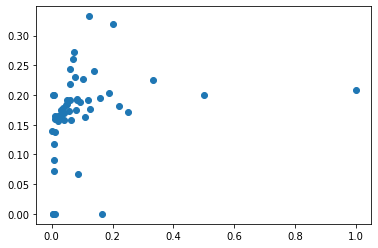

In [34]:
x=[x[0] for x in male_distribution]
y=[x[1] for x in male_distribution]
plt.scatter(x, y)
plt.show()

In [84]:
from sklearn.linear_model import LogisticRegression

In [135]:
target = np.array([x[1] for x in gender_distributions])
features = np.array([x[2] for x in gender_distributions])
data = pd.DataFrame({"features": features, "target": target})
#features = (features - np.mean(features)) / np.std(features)
data

,features,target
0,0.1667,0
1,0.1176,0
2,0.0000,0
3,0.1220,0
4,0.0426,1
...,...,...
15372,0.1081,0
15373,0.1463,0
15374,0.2222,1
15375,0.2500,0


In [132]:
target_index = data[data["target"] == 0].index
random_indices = np.random.choice(target_index, 3155, replace=False)
men = data.loc[random_indices]
women = data[data["target"] == 1]
training = pd.concat([men,women])
training

,features,target
4344,0.0806,0
11397,0.2857,0
14174,0.2000,0
6529,0.2143,0
709,0.2000,0
...,...,...
15349,0.1364,1
15356,0.1750,1
15361,0.2083,1
15371,0.2143,1


In [136]:
model = LogisticRegression()
model.fit(training["features"].to_numpy().reshape(-1,1), training["target"])

LogisticRegression()

In [137]:
np.mean((np.around(model.predict(data["features"].to_numpy().reshape(-1,1))) == data["target"].to_numpy()))

0.5771606945437991

In [138]:
model.summary()

AttributeError: 'LogisticRegression' object has no attribute 'summary'

In [130]:
np.count_nonzero(target)

3155

In [6]:
cursor.execute("select af.Name, a.Gender, count(*) from Authors a, affiliatedTo t, Affiliations af where a.AuthorID = t.AuthorID and t.affiliatedTo = af.AffiliationID group by af.Name, a.Gender")
gender_aff_distribution_raw = cursor.fetchall()
gender_aff_distribution_raw

[('None', None, 1),
 ('University of Alberta', 0, 88),
 ('University of Alberta', 1, 22),
 ('Alberta Machine Intelligence Institute', 0, 1),
 ('Synapse Partners', 0, 1),
 ('SRI International', 0, 63),
 ('SRI International', 1, 13),
 ('Universidad de Málaga', 0, 30),
 ('Universidad de Málaga', 1, 6),
 ('University of Cambridge', 0, 199),
 ('University of Cambridge', 1, 31),
 ('University of Cambridge', None, 1),
 ('Duke University', 0, 151),
 ('Duke University', 1, 38),
 ('Duke University', None, 1),
 ('California Institute of Technology', None, 2),
 ('California Institute of Technology', 0, 199),
 ('California Institute of Technology', 1, 28),
 ('ATR', 0, 1),
 ('Ritsumeikan University', 0, 15),
 ('McGill University', 0, 89),
 ('McGill University', 1, 24),
 ('University of British Columbia', 0, 141),
 ('University of British Columbia', None, 2),
 ('University of British Columbia', 1, 23),
 ('University of Southern California', 0, 200),
 ('University of Southern California', 1, 32),
 ('U

In [7]:
gender_aff_distribution_dict = {}
gender_aff_distribution = {}
for gender_amount in gender_aff_distribution_raw:
    if gender_amount[0] not in gender_aff_distribution_dict:
        gender_aff_distribution_dict[gender_amount[0]] = {}
    gender_aff_distribution_dict[gender_amount[0]][gender_amount[1]] = gender_amount[2]
for gender_aff in gender_aff_distribution_dict.items():
    curret_key = gender_aff[0]
    gender_aff = gender_aff[1]
    current_dist = []
    total = 0
    if 0 in gender_aff:
        current_dist.append(gender_aff[0])
        total += gender_aff[0]
    else:
        current_dist.append(0)
    if 1 in gender_aff:
        current_dist.append(gender_aff[1])
        total += gender_aff[1]
    else:
        current_dist.append(0)
    if None in gender_aff:
        current_dist.append(gender_aff[None])
        total += gender_aff[None]
    else:
        current_dist.append(0)
    current_dist.append(total)
    gender_aff_distribution[curret_key] = current_dist

In [8]:
sorted_gender_aff_distribution = {k: v for k, v in sorted(gender_aff_distribution.items(), key=lambda item: item[1][3], reverse=True)}
male =  [x[0] for x in sorted_gender_aff_distribution.values()][1:11]
female =  [x[1] for x in sorted_gender_aff_distribution.values()][1:11]
none_gender =  [x[2] for x in sorted_gender_aff_distribution.values()][1:11]
labels = [label for label in sorted_gender_aff_distribution][1:11]
most_male =  [(x[0],x[1][0]/x[1][3]) for x in sorted_gender_aff_distribution.items() if x[1][3] > 200]
most_female =  [(x[0],x[1][1]/x[1][3]) for x in sorted_gender_aff_distribution.items() if x[1][3] > 200]
{k: v for k, v in sorted(most_male, key=lambda item: item[1], reverse=True)}

{'Technische Universität München': 0.9247787610619469,
 'Google': 0.9,
 'Siemens': 0.8936170212765957,
 'ETH Zurich': 0.8925373134328358,
 'Imperial College London': 0.8820754716981132,
 'California Institute of Technology': 0.868995633187773,
 'University of Oxford': 0.8648648648648649,
 'University of Cambridge': 0.8614718614718615,
 'University of Minnesota': 0.8598130841121495,
 'University of Southern California': 0.8547008547008547,
 'Johns Hopkins University': 0.8543307086614174,
 'Max-Planck-Institut': 0.8533333333333334,
 'IBM': 0.8513931888544891,
 'Massachusetts Institute of Technology': 0.8472222222222222,
 'Purdue University': 0.84688995215311,
 'Carnegie Mellon University': 0.8406593406593407,
 'Georgia Institute of Technology': 0.8373702422145328,
 'Stanford University': 0.8355481727574751,
 'university of illinois': 0.8333333333333334,
 'Inria': 0.8239700374531835,
 'University of California': 0.823965410747375,
 'Microsoft': 0.8230277185501066,
 'Swiss Federal Institut

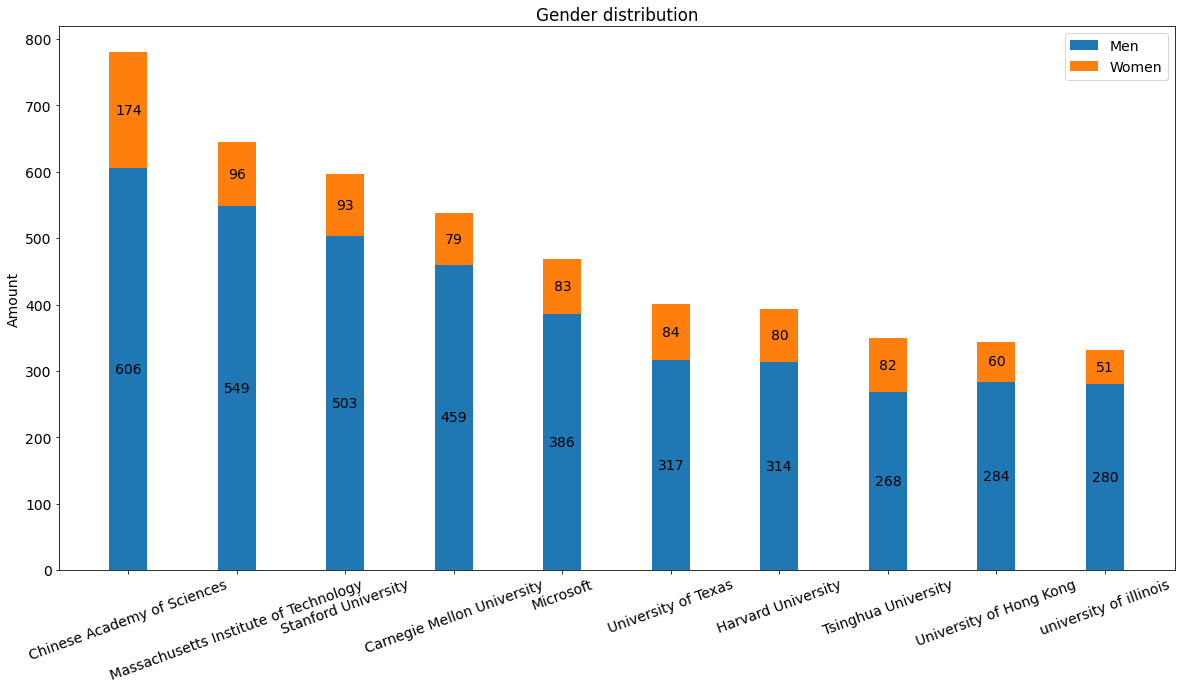

In [22]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(20, 10))

width = 0.35
p1 = ax.bar(labels, male, width, label='Men')
p2 = ax.bar(labels, female, width, bottom=male,
       label='Women')
ax.tick_params(axis='x', labelrotation=20)
ax.set_ylabel('Amount')
ax.set_title('Gender distribution')
ax.legend()
ax.bar_label(p1, label_type="center")
ax.bar_label(p2, label_type="center")
plt.show()

# Authors

325


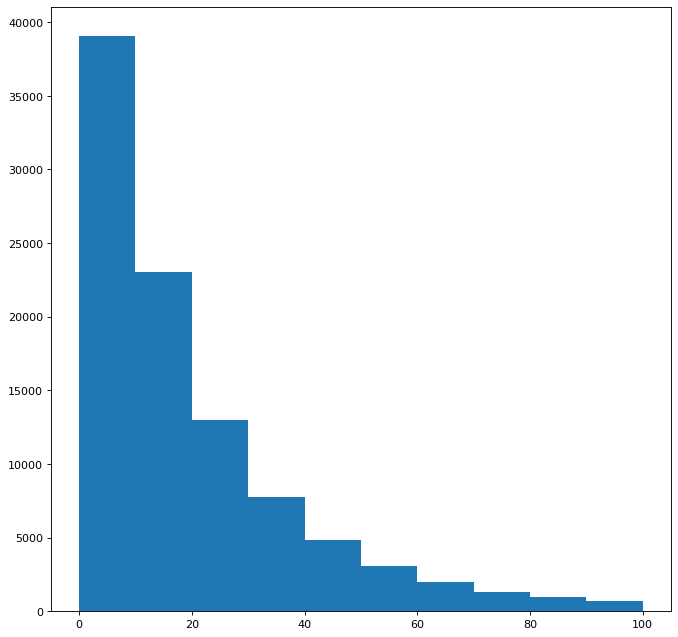

In [14]:
cursor.execute("select a.hIndex from Authors a where a.hIndex is not NULL")
hIndex_values = [x[0] for x in cursor.fetchall()]
print(max(hIndex_values))
figure(figsize=(10, 10), dpi=80)
plt.hist(hIndex_values, bins=10, range=(0,100))

plt.show()

# Reference Analysis

In [14]:
cursor.execute("SELECT AVG(p.ReferenceCount) FROM Papers p WHERE p.Leaf = FALSE")
avg_references = float(cursor.fetchone()[0])
cursor.execute("SELECT p.ReferenceCount FROM Papers p WHERE p.Leaf = FALSE")
reference_count = statistics.median([ref[0] for ref in cursor.fetchall()])
cursor.execute("SELECT MIN(p.ReferenceCount), MAX(p.ReferenceCount) FROM Papers p WHERE p.Leaf = FALSE")
borders = cursor.fetchall()[0]
print(f"Average references: {avg_references}")
print(f"Median references: {reference_count}")
print(f"Min: {borders[0]}")
print(f"Max: {borders[1]}")

Average references: 31.0119
Median references: 29.0
Min: 1
Max: 70


In [144]:
y

[]

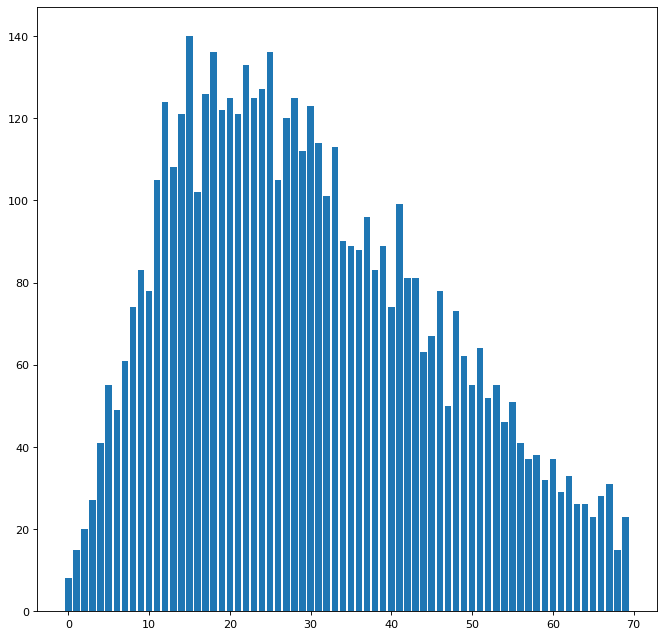

In [3]:
cursor.execute("SELECT p.ReferenceCount, count(*) FROM Papers p WHERE p.Leaf = FALSE group by p.ReferenceCount order by p.ReferenceCount")
items = cursor.fetchall()
ref_distribution = [item[1] for item in items]
cursor.execute("SELECT p.ReferenceCount, AVG(c) FROM Papers p, (select a.PaperID as paperID,count(*) as c from authoredBy a group by a.PaperID) a WHERE p.PaperID = a.PaperID and p.Leaf = FALSE group by ReferenceCount order by ReferenceCount")
items = cursor.fetchall()
avg_author_count = [item[1] for item in items]
figure(figsize=(10, 10), dpi=80)
plt.bar(list(range(len(ref_distribution))), ref_distribution)
#sns.distplot(ref_distribution, kde=True, bins=14, hist=True)
plt.show()

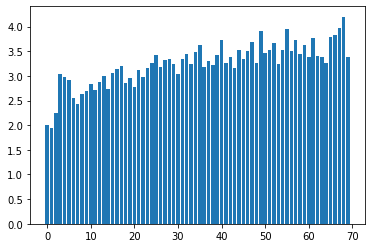

In [156]:
plt.bar(list(range(len(ref_distribution))), avg_author_count)
plt.show()

In [154]:
avg_author_count

[Decimal('2.0000'),
 Decimal('1.9333'),
 Decimal('2.2500'),
 Decimal('3.0370'),
 Decimal('2.9756'),
 Decimal('2.9091'),
 Decimal('2.5510'),
 Decimal('2.4262'),
 Decimal('2.6351'),
 Decimal('2.6867'),
 Decimal('2.8333'),
 Decimal('2.7048'),
 Decimal('2.8710'),
 Decimal('3.0000'),
 Decimal('2.7355'),
 Decimal('3.0643'),
 Decimal('3.1471'),
 Decimal('3.1984'),
 Decimal('2.8456'),
 Decimal('2.9590'),
 Decimal('2.7760'),
 Decimal('3.1157'),
 Decimal('2.9699'),
 Decimal('3.1600'),
 Decimal('3.2520'),
 Decimal('3.4191'),
 Decimal('3.1714'),
 Decimal('3.3167'),
 Decimal('3.3360'),
 Decimal('3.2411'),
 Decimal('3.0407'),
 Decimal('3.3509'),
 Decimal('3.4455'),
 Decimal('3.2478'),
 Decimal('3.4889'),
 Decimal('3.6180'),
 Decimal('3.1818'),
 Decimal('3.3021'),
 Decimal('3.2169'),
 Decimal('3.4270'),
 Decimal('3.7297'),
 Decimal('3.2626'),
 Decimal('3.3827'),
 Decimal('3.1605'),
 Decimal('3.5238'),
 Decimal('3.3433'),
 Decimal('3.5128'),
 Decimal('3.6800'),
 Decimal('3.2603'),
 Decimal('3.9032'),


In [140]:
len(ref_distribution)

5280

# Graph Analysis

In [4]:
cursor.execute("SELECT r.ReferencedByID,r.ReferenceID FROM referencedBy r")
references_all = cursor.fetchall()
cursor.execute("SELECT p.PaperID FROM Papers p")
papers_all = [paper_id[0] for paper_id in cursor.fetchall()]

In [5]:
G = nx.DiGraph()
G.add_nodes_from(papers_all)
G.add_edges_from(references_all)
nx.info(G)

/tmp/ipykernel_35820/2060462606.py:4: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G)


'DiGraph with 589391 nodes and 2836598 edges'

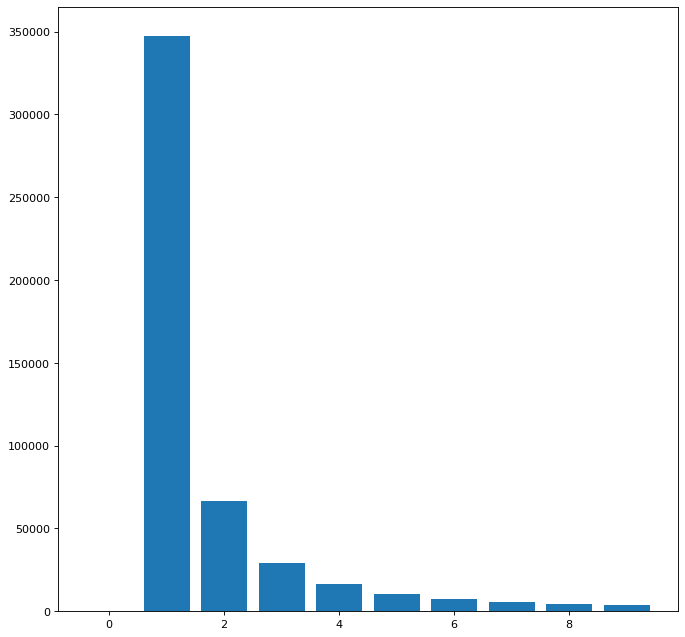

In [6]:
density = nx.density(G)
degree_hist = nx.degree_histogram(G)
figure(figsize=(10, 10), dpi=80)
plt.bar(range(len(degree_hist[0:10])), degree_hist[0:10])
plt.show()

In [7]:
print("Strong Connectivity")
print(f"Number of strongly connected components: {nx.number_strongly_connected_components(G)}")
print("Weak Connectivity")
print(f"Number of weakly connected components: {nx.number_weakly_connected_components(G)}")
weak_components_length = []
weak_components = []
for wc in nx.weakly_connected_components(G):
    weak_components_length.append(len(wc))
    weak_components.append(wc)
print(f"Unique sizes of weak components: {sorted(set(weak_components_length), reverse=True)}")


Strong Connectivity
Number of strongly connected components: 586905
Weak Connectivity
Number of weakly connected components: 476
Unique sizes of weak components: [587422, 70, 66, 61, 43, 33, 32, 31, 28, 27, 26, 23, 22, 21, 19, 18, 17, 16, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
